## Import the data

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style('ticks')
colors = sns.color_palette()

from msmbuilder.dataset import dataset
xyz = dataset("md.loop_*.xtc",
              topology='md.loop_1.gro')

In [2]:

#xyz = [t[::10] for t in xyz]
print("{} trajectories".format(len(xyz)))
# msmbuilder does not keep track of units! You must keep track of your
# data's timestep
to_ns = 0.01
print("with length {} ns".format(set(len(x)*to_ns for x in xyz)))

15 trajectories
with length {500.01} ns


## Featurise and scale

In [3]:
from msmbuilder.featurizer import DihedralFeaturizer
featurizer = DihedralFeaturizer(types=['phi', 'psi'])
diheds = xyz.fit_transform_with(featurizer, 'diheds/',fmt='dir-npy')

print(xyz[0].xyz.shape)
print(diheds[0].shape)

(50001, 447, 3)
(50001, 160)


In [4]:
from msmbuilder.preprocessing import RobustScaler
scaler = RobustScaler()
scaled_diheds = diheds.fit_transform_with(scaler, 'scaled_diheds/', fmt='dir-npy')

print(diheds[0].shape)
print(scaled_diheds[0].shape)

/Users/sbamos/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/sbamos/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


(50001, 160)
(50001, 160)


In [5]:
print(scaled_diheds[0])

[[-0.43541947  0.74884593 -0.46365178 ... -0.1658263   0.85913795
   0.77602136]
 [ 0.7787567  -0.4339848  -0.1790537  ... -0.13293637  1.0276759
  -0.11203236]
 [ 0.4853971  -0.11113638 -0.380626   ... -0.03015406  0.47415286
  -0.9864695 ]
 ...
 [ 1.2212926   0.5106154  -0.3353196  ...  0.28151995  0.8568613
  -0.19125319]
 [ 1.1494826  -0.35661125 -0.33929476 ... -0.7897709   0.5519864
  -0.27255228]
 [-0.38789058  0.78924495 -0.47034463 ...  0.4881509   0.2837296
  -0.22157344]]


ValueError: X must have 2 or fewer dimensions

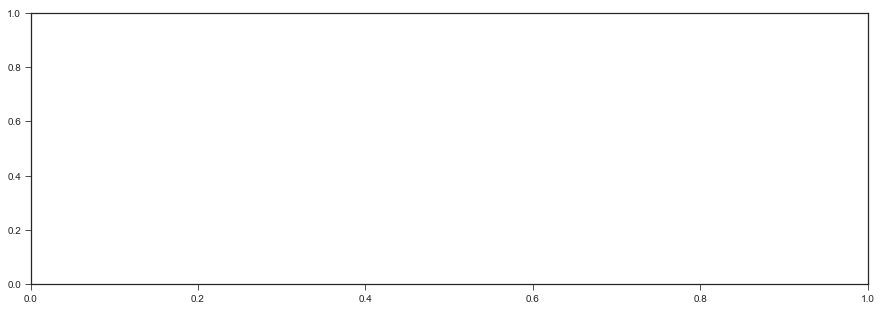

In [6]:
def plot_box(ax):
#    n_feats_plot = min(scaled_diheds[0].shape())
    ax.boxplot(scaled_diheds,#[:, :100],
               boxprops={'color': colors[0]},
               whiskerprops={'color': colors[0]},
               capprops={'color': colors[0]},
               medianprops={'color': colors[2]},
               )

#    if fxx[1].shape() > 100:
#        ax.annotate("(Only showing the first 100 features)",
#                    xy=(0.05, 0.95),
#                    xycoords='axes fraction',
#                    fontsize=14,
#                    va='top',
#                    )

    ax.set_xlabel("Feature Index", fontsize=16)
    xx = np.arange(0, n_feats_plot, 10)
    ax.set_xticks(xx)
    ax.set_xticklabels([str(x) for x in xx])
    ax.set_xlim((0, n_feats_plot + 1))
    ax.set_ylabel("Feature Value", fontsize=16)


## Plot
fig, ax = plt.subplots(figsize=(15, 5))
plot_box(ax)
fig.tight_layout()
plt.show()

## tICA

In [192]:
from msmbuilder.decomposition import tICA

## Load
tica_model = tICA(n_components=5, lag_time=100, kinetic_mapping=True)
tica_model = scaled_diheds.fit_with(tica_model)
tica_trajs = scaled_diheds.transform_with(tica_model, 'ticas/', fmt='dir-npy')

print(diheds[0].shape)
print(tica_trajs[0].shape)

(50001, 160)
(50001, 5)


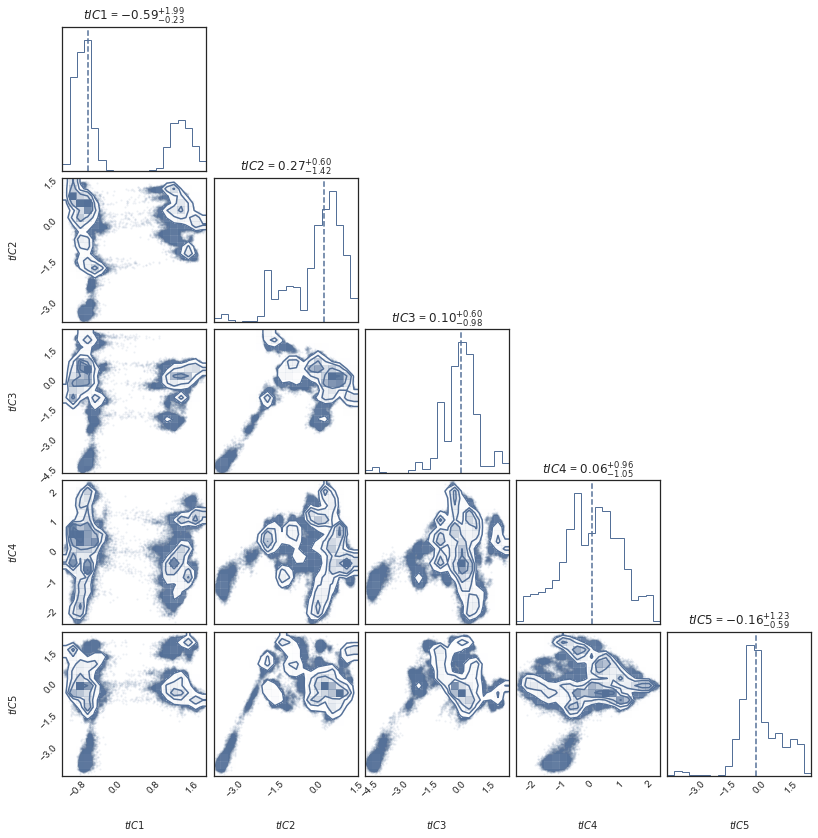

In [218]:
%matplotlib inline
import msmexplorer as msme
import numpy as np
txx = np.concatenate(tica_trajs)
_ = msme.plot_histogram(txx, labels=['$tIC1$', '$tIC2$', '$tIC3$', '$tIC4$', '$tIC5$'],
                    color='rawdenim', quantiles=(0.5,), smooth=0.5, show_titles=True)

/Users/sbamos/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/Users/sbamos/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


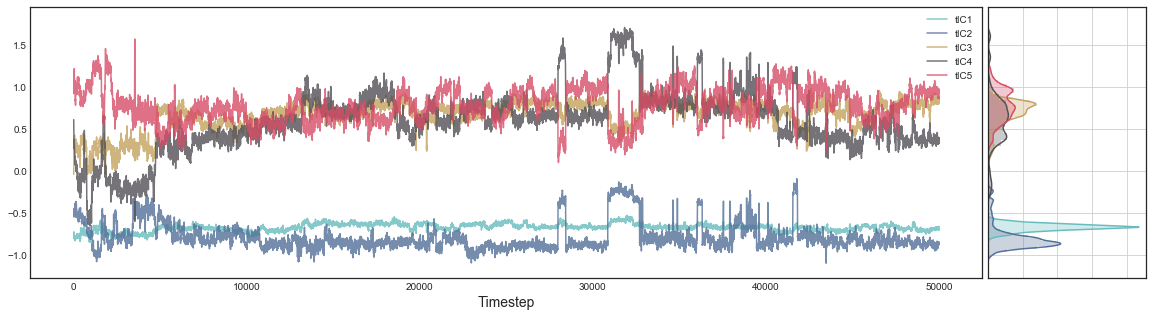

In [194]:
import msmexplorer as msme

ax, side_ax = msme.plot_trace(tica_trajs[0][:, 0], window=10,
                              label='tIC1', xlabel='Timestep')
_ = msme.plot_trace(tica_trajs[0][:, 1], window=10, label='tIC2',
                    xlabel='Timestep', color='rawdenim', ax=ax,
                    side_ax=side_ax)
__ = msme.plot_trace(tica_trajs[0][:, 2], window=10, label='tIC3',
                    xlabel='Timestep', color='dijon', ax=ax,
                    side_ax=side_ax)
___ = msme.plot_trace(tica_trajs[0][:, 3], window=10, label='tIC4',
                    xlabel='Timestep', color='carbon', ax=ax,
                    side_ax=side_ax)
____ = msme.plot_trace(tica_trajs[0][:, 4], window=10, label='tIC5',
                    xlabel='Timestep', color='pomegranate', ax=ax,
                    side_ax=side_ax)

## Clustering

In [196]:
from msmbuilder.cluster import KCenters
from msmbuilder.cluster import KMeans
clusterer = KCenters(n_clusters=22, random_state=42)
clustered_trajs = tica_trajs.fit_transform_with(
    clusterer, 'kmeans/', fmt='dir-npy'
)

print(tica_trajs[0].shape)
print(clustered_trajs[0].shape)

(50001, 5)
(50001,)


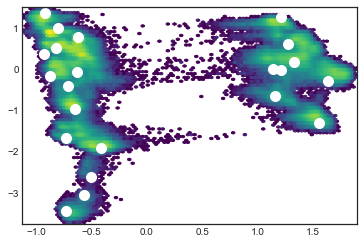

In [197]:
from matplotlib import pyplot as plt
plt.hexbin(txx[:,0], txx[:,1], bins='log', mincnt=1, cmap='viridis')
plt.scatter(clusterer.cluster_centers_[:,0],
            clusterer.cluster_centers_[:,1], 
            s=100, c='w')

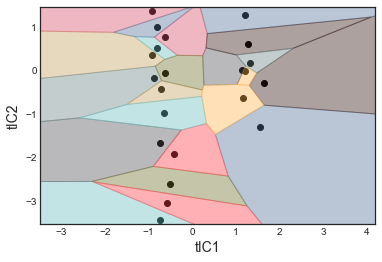

In [198]:
_ = msme.plot_voronoi(clusterer, xlabel='tIC1', ylabel='tIC2')


## MSM

/Users/sbamos/anaconda3/lib/python3.6/site-packages/msmbuilder/msm/msm.py:567: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigma2)


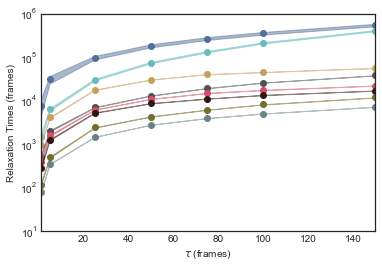

In [199]:
from msmbuilder.msm import MarkovStateModel
msm_list = [
    MarkovStateModel(lag_time=x, n_timescales=8, verbose=False)
                     for x in [1, 5, 25, 50, 75, 100, 150 ]
]

for msm in msm_list:
    msm.fit(clustered_trajs)
    
_ = msme.plot_implied_timescales(msm_list,
                                  xlabel=r'$\tau$ (frames)',
                                  ylabel='Relaxation Times (frames)')

In [200]:
from msmbuilder.msm import MarkovStateModel
from msmbuilder.utils import dump
msm = MarkovStateModel(lag_time=60, n_timescales=10)
msm.fit(clustered_trajs)

MSM contains 1 strongly connected component above weight=0.02. Component 0 selected, with population 100.000000%


MarkovStateModel(ergodic_cutoff='on', lag_time=60, n_timescales=10,
         prior_counts=0, reversible_type='mle', sliding_window=True,
         verbose=True)

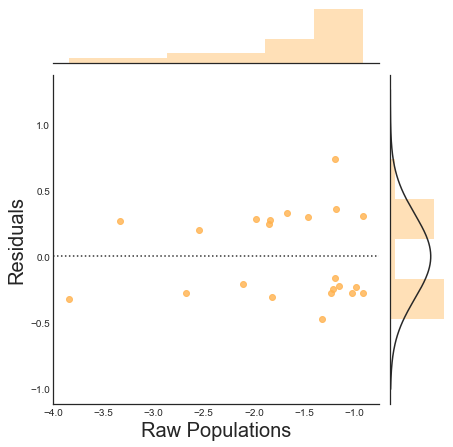

In [201]:
_ = msme.plot_pop_resids(msm, color='tarragon')


In [202]:
print(msm.summarize())

Markov state model
------------------
Lag time         : 60
Reversible type  : mle
Ergodic cutoff   : on
Prior counts     : 0

Number of states : 22
Number of nonzero entries in counts matrix : 126 (26.03305785123967%)
Nonzero counts matrix entries:
    Min.   : 0.0
    1st Qu.: 0.4
    Median : 1.8
    Mean   : 99.1
    3rd Qu.: 21.0
    Max.   : 1445.0

Total transition counts :
    12485.250000000002 counts
Total transition counts / lag_time:
    208.08750000000003 units
Timescales:
    [218421.72, 93800.80, 34494.35, 15548.97, 12812.95, 9720.24, 5073.44, 3287.32, 2037.64, 1753.48]  units



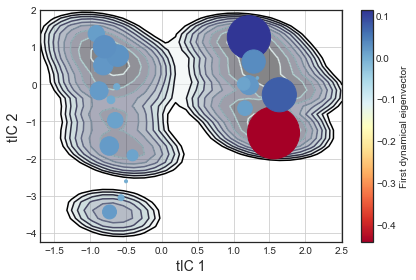

In [203]:
assignments = clusterer.partial_transform(txx)
assignments = msm.partial_transform(assignments)
msme.plot_free_energy(txx, obs=(0, 1), n_samples=10000,
                      pi=msm.populations_[assignments],
                      xlabel='tIC 1', ylabel='tIC 2')
plt.scatter(clusterer.cluster_centers_[msm.state_labels_, 0],
            clusterer.cluster_centers_[msm.state_labels_, 1],
            s=1e4 * msm.populations_,       # size by population
            c=msm.left_eigenvectors_[:, 1], # color by eigenvector
            cmap="RdYlBu",
            zorder=3) 
plt.colorbar(label='First dynamical eigenvector')
plt.tight_layout()

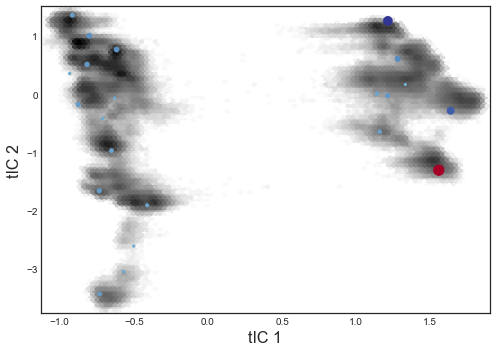

In [204]:
## Plot microstates
def plot_microstates(ax):
    ax.hexbin(txx[:, 0], txx[:, 1],
              cmap='Greys',
              mincnt=1,
              bins='log',
              )

    scale = 100 / np.max(msm.populations_)
    add_a_bit = 5
    ax.scatter(clusterer.cluster_centers_[msm.state_labels_, 0],
               clusterer.cluster_centers_[msm.state_labels_, 1],
               s=scale * msm.populations_ + add_a_bit,
               c=msm.left_eigenvectors_[:, 1],
               cmap='RdYlBu'
               )
    ax.set_xlabel("tIC 1", fontsize=16)
    ax.set_ylabel("tIC 2", fontsize=16)
    #ax.colorbar(label='First Dynamical Eigenvector', fontsize=16)


## Plot
fig, ax = plt.subplots(figsize=(7, 5))
plot_microstates(ax)
fig.tight_layout()
plt.show()
#fig.savefig('msm-microstates.pdf')

# The microstate centers are shown as circles on the tIC heatmap. 
# They are sized according to state population. 
# They are colored according to the first dynamical eigenvector. 
# The slowest processes is a transition from red states to blue.

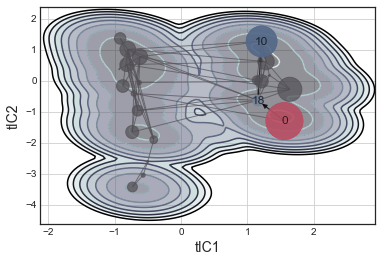

In [206]:
data = np.concatenate(tica_trajs, axis=0)
pi_0 = msm.populations_[np.concatenate(assignments, axis=0)]
rs = np.random.RandomState(42) 

ax = msme.plot_free_energy(data, obs=(0, 1), temperature=323., n_samples=10000,
                          pi=pi_0, gridsize=100, vmax=10., vmin=-1.,
                          n_levels=10, cut=5, xlabel='tIC1',
                          ylabel='tIC2', random_state=rs,
                          shade=True,
                      clabel=False,
                      clabel_kwargs={'fmt': '%.1f'},
                      cbar=False,
                      cbar_kwargs={'format': '%.1f', 'label': 'Free energy (kcal/mol)'})

pi_0 = msm.populations_[np.concatenate(assignments, axis=0)]
rs = np.random.RandomState(42)

pos = dict(zip(range(clusterer.n_clusters), clusterer.cluster_centers_[:,[0,1]]))
#pos = dict(zip(range(clusterer.n_clusters), clusterer.cluster_centers_))
_ = msme.plot_msm_network(msm, pos=pos, node_color='carbon',
                          with_labels=False)

# Top Transition Pathway
w = (msm.left_eigenvectors_[:, 1] - msm.left_eigenvectors_[:, 1].min())
w /= w.max()
cmap = msme.utils.make_colormap(['pomegranate', 'lightgrey', 'rawdenim'])
_ = msme.plot_tpaths(msm, [0], [10], pos=pos, node_color=cmap(w),
                     alpha=.7, edge_color='black', ax=ax)

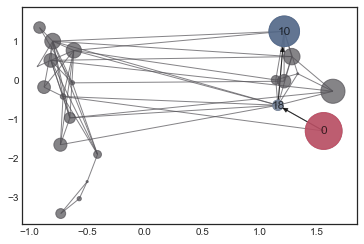

In [207]:
# MSM Network
_ = msme.plot_msm_network(msm, pos=pos, node_color='carbon',
                          with_labels=False)

# Top Transition Pathway
w = (msm.left_eigenvectors_[:, 1] - msm.left_eigenvectors_[:, 1].min())
w /= w.max()
cmap = msme.utils.make_colormap(['pomegranate', 'lightgrey', 'rawdenim'])
_ = msme.plot_tpaths(msm, [0], [10], pos=pos, node_color=cmap(w),
                     alpha=.7, edge_color='black')

In [208]:
msm.timescales_

array([218421.72114931,  93800.80466913,  34494.34714987,  15548.96562902,
        12812.95132427,   9720.23662019,   5073.43762883,   3287.32489022,
         2037.63620416,   1753.48139376])

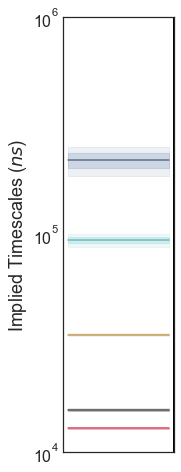

In [209]:
msme.plot_timescales(msm, n_timescales=5,
                     ylabel='Implied Timescales ($ns$)')

## Macrostate Model

In [216]:
from msmbuilder.lumping import PCCAPlus
pcca = PCCAPlus.from_msm(msm, n_macrostates=5)
macro_trajs = pcca.transform(clustered_trajs)

/Users/sbamos/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


Optimization terminated successfully.
         Current function value: -4.990086
         Iterations: 10
         Function evaluations: 179


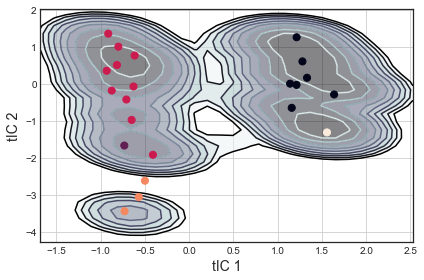

In [219]:
msme.plot_free_energy(txx, obs=(0, 1), n_samples=10000,
                      pi=msm.populations_[assignments],
                      xlabel='tIC 1', ylabel='tIC 2')
plt.scatter(clusterer.cluster_centers_[msm.state_labels_, 0],
            clusterer.cluster_centers_[msm.state_labels_, 1],
            s=50,
            c=pcca.microstate_mapping_,
            zorder=3
           )
plt.tight_layout()

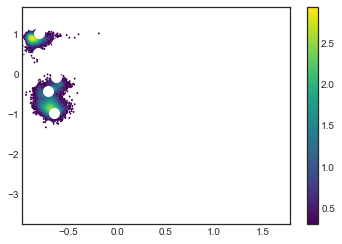

In [223]:
from msmbuilder.utils.nearest import KDTree

sub_tica_trajs = [tica_trajs[i] for i in np.arange(0,len(tica_trajs),10)]
ktree=KDTree(sub_tica_trajs)
txx=np.concatenate(sub_tica_trajs)
sl=list(pcca.mapping_.keys())

sns.set_style('white')
p=plt.hexbin(txx[:,0],txx[:,1],bins='log',mincnt=1,cmap='viridis')
plt.scatter(clusterer.cluster_centers_[sl,0],clusterer.cluster_centers_[sl,1],s=100,c='white')
plt.colorbar(p)

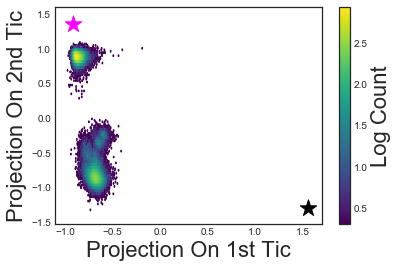

In [224]:
ind1 = np.where(clusterer.cluster_centers_[:,0]>1)[0][0]
ind2 = np.where(clusterer.cluster_centers_[:,0]<-0.75)[0][1]

import seaborn as sns
#figure(figsize=(12,8))
sns.set_style('white')
p=plt.hexbin(txx[:,0],txx[:,1],bins='log',mincnt=1,cmap='viridis')
plt.scatter(clusterer.cluster_centers_[ind1,0],clusterer.cluster_centers_[ind1,1],s=300,c='black',marker='*')
plt.scatter(clusterer.cluster_centers_[ind2,0],clusterer.cluster_centers_[ind2,1],s=300,c='magenta',marker='*')

plt.xlabel("Projection On 1st Tic",size=22)
plt.ylabel("Projection On 2nd Tic", size=22)
cb=plt.colorbar(p)
cb.set_label(size=22,label="Log Count")

In [227]:
trj_ds = xyz
trj_list = []
for cind in [ind1,ind2]:
    pt = clusterer.cluster_centers_[cind]
    _,(t,f) = ktree.query(pt)
    print(t,f)
    trj_list.append(trj_ds[t*10][f])
    
trj = trj_list[0]+trj_list[1:]
trj.save_pdb("two.pdb")

0 815
1 11


IndexError: list index out of range

## PCA

/Users/sbamos/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/Users/sbamos/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


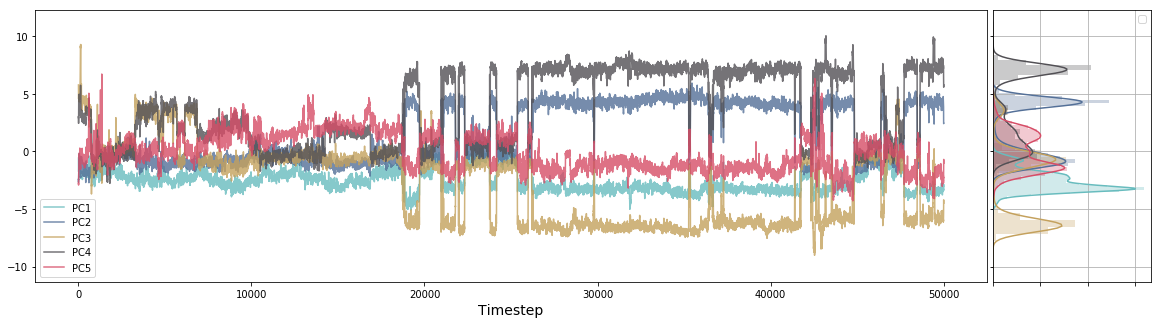

In [89]:
from msmbuilder.decomposition import PCA
pca_model = PCA(n_components=5)
pca_trajs = pca_model.fit_transform(scaled_diheds)

ax, side_ax = msme.plot_trace(pca_trajs[0][:, 0], window=10,
                              label='PC1', xlabel='Timestep')
_ = msme.plot_trace(pca_trajs[0][:, 1], window=10, label='PC2',
                    xlabel='Timestep', color='rawdenim', ax=ax,
                    side_ax=side_ax)
__ = msme.plot_trace(pca_trajs[0][:, 2], window=10, label='PC3',
                    xlabel='Timestep', color='dijon', ax=ax,
                    side_ax=side_ax)
___ = msme.plot_trace(pca_trajs[0][:, 3], window=10, label='PC4',
                    xlabel='Timestep', color='carbon', ax=ax,
                    side_ax=side_ax)
____ = msme.plot_trace(pca_trajs[0][:, 4], window=10, label='PC5',
                    xlabel='Timestep', color='pomegranate', ax=ax,
                    side_ax=side_ax)

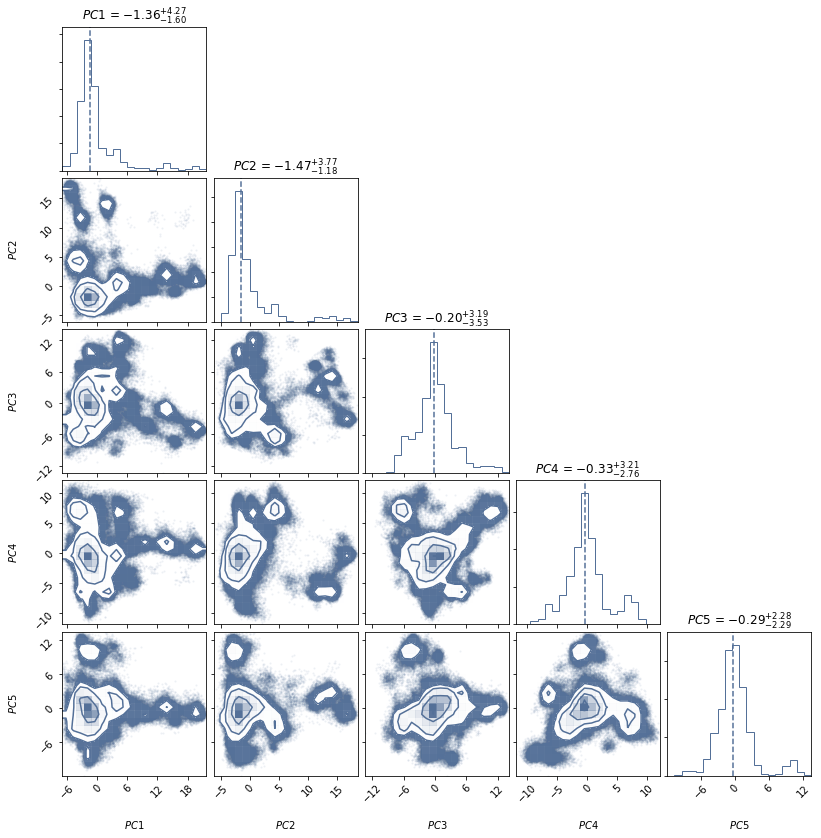

In [90]:
pxx = np.concatenate(pca_trajs)
_ = msme.plot_histogram(pxx, labels=['$PC1$', '$PC2$', '$PC3$', '$PC4$', '$PC5$'],
                    color='rawdenim', quantiles=(0.5,), smooth=0.5, show_titles=True)

In [91]:
#pca_model = PCA(n_components=2)
#pca_trajs = pca_model.fit_transform(scaled_diheds)

#ax, side_ax = msme.plot_trace(pca_trajs[0][:, 0], window=10,
#                              label='PC1', xlabel='Timestep')
#_ = msme.plot_trace(pca_trajs[0][:, 1], window=10, label='PC2',
#                    xlabel='Timestep', color='rawdenim', ax=ax,
#                    side_ax=side_ax)

In [92]:
#%matplotlib inline
#import msmexplorer as msme
#import numpy as np
#txx = np.concatenate(pca_trajs)
#_ = msme.plot_histogram(txx, labels=['$PC1$', '$PC2$'],
#                    show_titles=True)

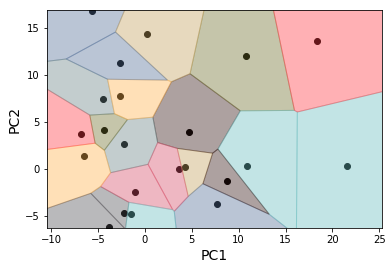

In [100]:
clusterer = KCenters(n_clusters=22, random_state=rs)
clustered_trajs = clusterer.fit_transform(pca_trajs)

_ = msme.plot_voronoi(clusterer, xlabel='PC1', ylabel='PC2')


Timescale 1: 775.39 ± 2.96 ns
Timescale 2: 256.63 ± 0.40 ns
Timescale 3: 244.96 ± 0.64 ns
Timescale 4: 219.77 ± 0.33 ns
Timescale 5: 146.59 ± 0.18 ns
Timescale 6: 126.62 ± 0.18 ns
Timescale 7: 65.49 ± 0.15 ns
Timescale 8: 62.15 ± 0.12 ns
Timescale 9: 47.85 ± 0.06 ns
Timescale 10: 24.53 ± 0.03 ns


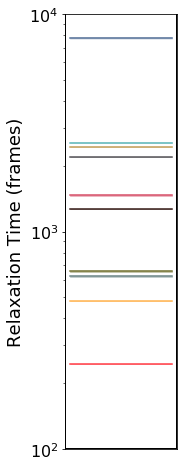

In [101]:
_ = msme.plot_timescales(msm, ylabel=r'Relaxation Time (frames)')

for i, (ts, ts_u) in enumerate(zip(msm.timescales_, msm.uncertainty_timescales())):
    timescale_ns = ts / 10
    uncertainty_ns = ts_u / 10
    print('Timescale %d: %.2f ± %.2f ns' % ((i + 1), timescale_ns, uncertainty_ns))

In [104]:
msm_list = [
    MarkovStateModel(lag_time=x, n_timescales=5, verbose=False)
                     for x in [1, 5, 25, 50, 75, 100, 125, 250]
]

for msm in msm_list:
    msm.fit(clustered_trajs)

/Users/sbamos/anaconda3/lib/python3.6/site-packages/msmbuilder/msm/msm.py:567: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigma2)


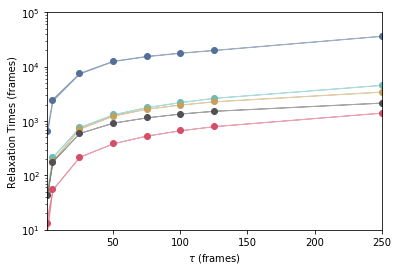

In [105]:
_ = msme.plot_implied_timescales(msm_list,
                                  xlabel=r'$\tau$ (frames)',
                                  ylabel='Relaxation Times (frames)')

In [106]:
msm = MarkovStateModel(lag_time=60, n_timescales=10)
assigns = msm.fit_transform(clustered_trajs)

MSM contains 1 strongly connected component above weight=0.02. Component 0 selected, with population 100.000000%


In [107]:
for i, (ts, ts_u) in enumerate(zip(msm.timescales_, msm.uncertainty_timescales())):
    timescale_ns = ts / 10
    uncertainty_ns = ts_u / 10
    print('Timescale %d: %.2f ± %.2f ns' % ((i + 1), timescale_ns, uncertainty_ns))

Timescale 1: 1387.76 ± 13.00 ns
Timescale 2: 152.97 ± 0.45 ns
Timescale 3: 142.95 ± 0.62 ns
Timescale 4: 104.26 ± 0.20 ns
Timescale 5: 45.44 ± 0.07 ns
Timescale 6: 37.62 ± 0.06 ns
Timescale 7: 31.06 ± 0.07 ns
Timescale 8: 20.70 ± 0.02 ns
Timescale 9: 14.95 ± 0.01 ns
Timescale 10: 13.94 ± 0.01 ns


/Users/sbamos/anaconda3/lib/python3.6/site-packages/msmbuilder/msm/msm.py:567: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigma2)


/Users/sbamos/anaconda3/lib/python3.6/site-packages/msmexplorer/plots/projection.py:16: RuntimeWarning: divide by zero encountered in log
  return - THERMO_CONSTANT * temperature * np.log(Z)


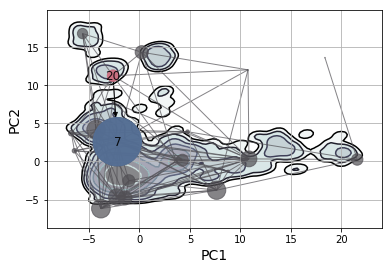

In [115]:
data = np.concatenate(pca_trajs, axis=0)
pi_0 = msm.populations_[np.concatenate(assigns, axis=0)]


# Free Energy Surface
ax = msme.plot_free_energy(data, obs=(0, 1), n_samples=10000,
                          pi=pi_0, gridsize=100, vmax=5.,
                          n_levels=8, cut=5, xlabel='PC1',
                          ylabel='PC2', random_state=rs)

# MSM Network
#pos = dict(zip(range(clusterer.n_clusters), clusterer.cluster_centers_))
pos = dict(zip(range(clusterer.n_clusters), clusterer.cluster_centers_[:,[0,1]]))
_ = msme.plot_msm_network(msm, pos=pos, node_color='carbon', with_labels=False)


# Top Transition Pathway
w = (msm.left_eigenvectors_[:, 1] - msm.left_eigenvectors_[:, 1].min())
w /= w.max()
cmap = msme.utils.make_colormap(['pomegranate', 'lightgrey', 'rawdenim'])
_ = msme.plot_tpaths(msm, [20], [7], pos=pos, node_color=cmap(w),
                     alpha=.9, edge_color='black', ax=ax)

## Contacts

/Users/sbamos/anaconda3/lib/python3.6/site-packages/msmexplorer/plots/misc.py:50: RuntimeWarning: invalid value encountered in true_divide
  data /= data.max()
/Users/sbamos/anaconda3/lib/python3.6/site-packages/msmexplorer/plots/misc.py:51: RuntimeWarning: invalid value encountered in less
  data[data < threshold] = 0.0


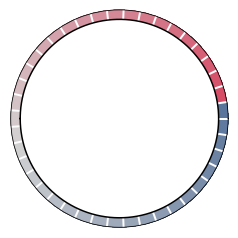

In [36]:
import mdtraj as md
from msmexplorer.utils import make_colormap

xyz = dataset("md.loop_15.xtc",
              topology='md.loop_1.gro')
# Compute Hydrogen Bonding Residue Pairs
baker_hubbard = md.baker_hubbard(xyz[0])
top = xyz[0].topology
pairs = [(top.atom(di).residue.index, top.atom(ai).residue.index)
         for di, _, ai in baker_hubbard]

# Create Hydrogen Bonding Network
hbonds = np.zeros((top.n_residues, top.n_residues))
hbonds[list(zip(*pairs))] = 1.

# Make a Colormap
cmap = make_colormap(['pomegranate', 'lightgray', 'rawdenim'])

# Plot Chord Diagram
msme.plot_chord(hbonds, cmap=cmap)

In [37]:
# Plot Stacked Distributions
#a = np.concatenate(assignments, axis=0)
#d = np.concatenate(diheds, axis=0)

# Plot Stacked Distributions of the sine of each Chi1 angle
# within an arbitrary set of states {2, 5, 0}
#path_data = [d[a == i][:, ::2] for i in [2, 5, 0]]
#msme.plot_stackdist(path_data)

## More Contacts

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
import os, sys

/Users/sbamos/anaconda3/lib/python3.6/site-packages/MDAnalysis/due.py:88: UserWarning: No module named 'duecredit'
  warnings.warn(str(err))


In [134]:
U = mda.Universe("md.loop_9.gro", "md.loop_9.xtc")

seq = 'GIIDILQSYRLVKKLEHSWKALLHDGDTVSVHRPSFYAERF'
print(list(seq))

['G', 'I', 'I', 'D', 'I', 'L', 'Q', 'S', 'Y', 'R', 'L', 'V', 'K', 'K', 'L', 'E', 'H', 'S', 'W', 'K', 'A', 'L', 'L', 'H', 'D', 'G', 'D', 'T', 'V', 'S', 'V', 'H', 'R', 'P', 'S', 'F', 'Y', 'A', 'E', 'R', 'F']


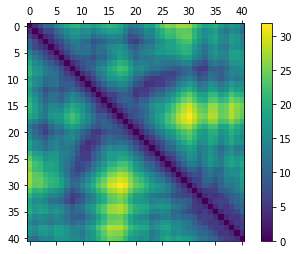

In [135]:
from MDAnalysis.analysis import distances

pep1 = U.select_atoms('name CA')
pep2 = U.select_atoms('name CA')
cmap  = distances.distance_array(pep1.positions, pep2.positions, box=pep1.dimensions)

fig, ax = plt.subplots()
ms = ax.matshow(cmap)
plt.colorbar(ms)

TypeError: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

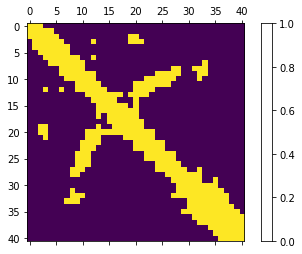

In [136]:
cutoff = 9  # ANGSTROM
contacts = cmap < cutoff

fig, ax = plt.subplots()
ms = ax.matshow(contacts)
plt.colorbar(ms)

/Users/sbamos/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


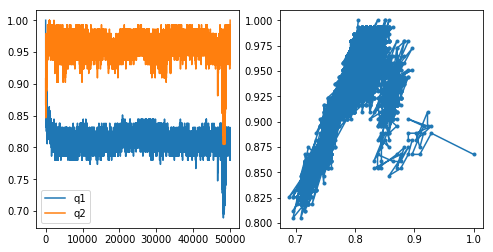

In [137]:
from MDAnalysis.analysis import contacts
q1q2 = contacts.q1q2(U, 'name CA', radius=8)
q1q2.run()

f, ax = plt.subplots(1, 2, figsize=plt.figaspect(0.5))
ax[0].plot(q1q2.timeseries[:, 0], q1q2.timeseries[:, 1], label='q1')
ax[0].plot(q1q2.timeseries[:, 0], q1q2.timeseries[:, 2], label='q2')
ax[0].legend(loc='best')
ax[1].plot(q1q2.timeseries[:, 1], q1q2.timeseries[:, 2], '.-')
f.show()

In [138]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#d = pd.DataFrame(cmap)
d = pd.DataFrame(cmap)#, columns=list(seq))

#print(d)

In [139]:
corr = d.corr()

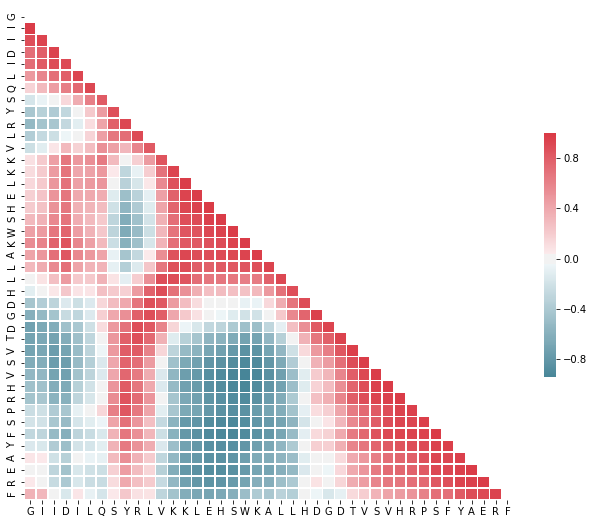

In [140]:
# generate a mask for the upper triangle so not as messy

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
c = sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, xticklabels=list(seq), yticklabels=list(seq), linewidths=.5, cbar_kws={"shrink": .5})

average contacts = 0.9922801543969121


/Users/sbamos/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


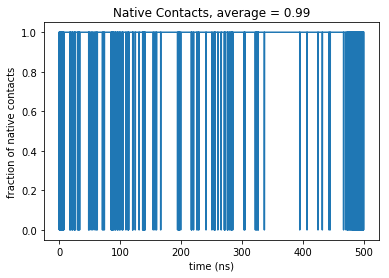

In [141]:
import MDAnalysis as mda
from MDAnalysis.analysis import contacts
import matplotlib.pyplot as plt


sel_1 = "resname ARG"
sel_2 = "resname LYS"
# reference groups 
group_1 = U.select_atoms(sel_1)
group_2 = U.select_atoms(sel_2)
# set up analysis of native contacts 
# distance <6 A
ca1 = contacts.Contacts(U, selection=(sel_1, sel_2),
                        refgroup=(group_1, group_2), radius=6.0)
# iterate through trajectory and perform analysis of "native contacts" Q
ca1.run()
# print number of average contacts
average_contacts = np.mean(ca1.timeseries[:, 1])
print('average contacts = {}'.format(average_contacts))
# plot time series q(t)
f, ax = plt.subplots()
ax.plot((ca1.timeseries[:, 0])/100, ca1.timeseries[:, 1])
ax.set(xlabel='time (ns)', ylabel='fraction of native contacts',
       title='Native Contacts, average = {:.2f}'.format(average_contacts))
fig.show()